In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow
import random

# Set random seed for reproducibility
np.random.seed(0)
tensorflow.random.set_seed(0)
random.seed(0)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Bidirectional, Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load and preprocess the data
df = pd.read_excel('/content/drive/MyDrive/seema/Copy of val.xlsx')

In [6]:
df.head()

,Tweet,class,Sub,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,كتبك هي من تسب الآخرين و تصفهم بأقذر الألقاب م...,1,R-HS,NaN,NaN,NaN
1,اخونجي متطرف يعشق الفتنه والخراب لغيره وعشان ك...,1,S-HS,NaN,NaN,NaN
2,احسنت هذا عباله كل واحد عايش في لندن خائن,0,NaN,NaN,NaN,NaN
3,الطيور على أشكالها تقع ، الطغاة يحتفلون بوتين ...,1,P-HS,NaN,NaN,NaN
4,هذا تاريخ الخبيث اللي تروجله ياوهمي متطرف اخون...,1,P-HS,NaN,NaN,ملاحظة


In [7]:
df = df[['Tweet','class','Sub']]

### **Preprocessing**

In [8]:
X = df['Tweet'].astype(str)
y = df['class']

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)


In [9]:
# sub_y = df['Sub'].values
# sub_y_train, sub_y_val = sub_y[train_idx], sub_y[val_idx]

### **Tokenization and padding**

In [10]:
max_words = 10000  # Max number of words in tokenizer
max_len = 62  # Max sequence length
embed_dim = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

### **Word Embedding Matrix**

In [11]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz; gunzip cc.ar.300.vec.gz

--2024-05-09 12:06:40--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G  54.1MB/s    in 29s     

2024-05-09 12:07:09 (42.5 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]



In [12]:
# Step 1: Load FastText Model
import gensim
fasttext_model = gensim.models.KeyedVectors.load_word2vec_format('/content/cc.ar.300.vec', binary=False)

In [13]:
# Step 2: Create Embedding Matrix from FastText
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))  # FastText vectors are 300-dimensional
for word, i in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_vector = fasttext_model[word]
        embedding_matrix[i] = embedding_vector

### **Models**

In [18]:
# Define a list of deep learning models to experiment with
models = [
    ('CNN', Sequential([
        Embedding(len(tokenizer.word_index) + 1, 300, weights=[embedding_matrix], input_length=max_len, trainable=False),
        Conv1D(128, 5, activation='relu',
               kernel_initializer=RandomNormal(mean=0.0, stddev=0.05),
                bias_initializer=RandomNormal(mean=0.0, stddev=0.05)),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ]))

]


### **Train 5 cross validation**

In [15]:
!export TF_DETERMINISTIC_OPS=1

In [16]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Training and evaluating CNN with 5-fold stratified cross-validation...
Epoch 1/100
50/50 [==============================] - 17s 296ms/step - loss: 0.6758 - accuracy: 0.5649 - val_loss: 0.6659 - val_accuracy: 0.5741
Epoch 2/100
50/50 [==============================] - 16s 316ms/step - loss: 0.6474 - accuracy: 0.6162 - val_loss: 0.6461 - val_accuracy: 0.6215
Epoch 3/100
50/50 [==============================] - 15s 293ms/step - loss: 0.6220 - accuracy: 0.6697 - val_loss: 0.6278 - val_accuracy: 0.6454
Epoch 4/100
50/50 [==============================] - 8s 159ms/step - loss: 0.5977 - accuracy: 0.6980 - val_loss: 0.6124 - val_accuracy: 0.6675
Epoch 5/100
50/50 [==============================] - 11s 222ms/step - loss: 0.5765 - accuracy: 0.7257 - val_loss: 0.5977 - val_accuracy: 0.6801
Epoch 6/100
50/50 [==============================] - 14s 282ms/step - loss: 0.5521 - accuracy: 0.7445 - val_loss: 0.5820 - val_accuracy: 0.6915
Epoch 7/100
50/50 [==============================] - 15s 295ms/ste

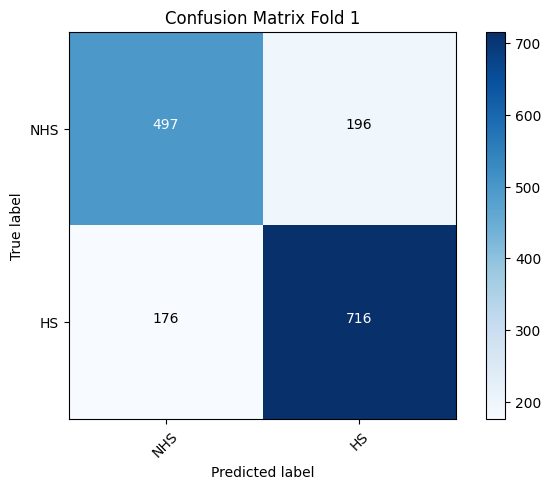

              precision    recall  f1-score   support

         NHS       0.74      0.72      0.73       693
          HS       0.79      0.80      0.79       892

    accuracy                           0.77      1585
   macro avg       0.76      0.76      0.76      1585
weighted avg       0.76      0.77      0.76      1585

Epoch 1/100
50/50 [==============================] - 18s 313ms/step - loss: 0.3335 - accuracy: 0.8777 - val_loss: 0.2860 - val_accuracy: 0.9129
Epoch 2/100
50/50 [==============================] - 14s 291ms/step - loss: 0.3150 - accuracy: 0.8895 - val_loss: 0.2856 - val_accuracy: 0.9091
Epoch 3/100
50/50 [==============================] - 15s 305ms/step - loss: 0.3000 - accuracy: 0.8974 - val_loss: 0.2841 - val_accuracy: 0.9028
Epoch 4/100
50/50 [==============================] - 13s 266ms/step - loss: 0.2868 - accuracy: 0.9048 - val_loss: 0.2841 - val_accuracy: 0.9009
Epoch 5/100
50/50 [==============================] - 10s 190ms/step - loss: 0.2721 - accuracy: 0.

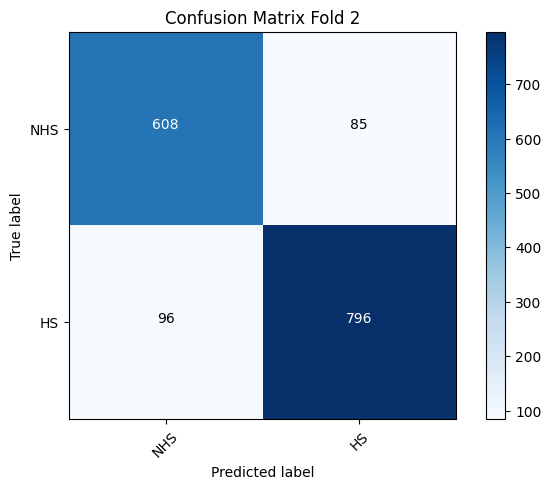

              precision    recall  f1-score   support

         NHS       0.86      0.88      0.87       693
          HS       0.90      0.89      0.90       892

    accuracy                           0.89      1585
   macro avg       0.88      0.88      0.88      1585
weighted avg       0.89      0.89      0.89      1585

Epoch 1/100
50/50 [==============================] - 14s 254ms/step - loss: 0.1459 - accuracy: 0.9623 - val_loss: 0.0926 - val_accuracy: 0.9886
Epoch 2/100
50/50 [==============================] - 9s 172ms/step - loss: 0.1294 - accuracy: 0.9688 - val_loss: 0.0922 - val_accuracy: 0.9886
Epoch 3/100
50/50 [==============================] - 14s 287ms/step - loss: 0.1175 - accuracy: 0.9763 - val_loss: 0.0922 - val_accuracy: 0.9861
Epoch 4/100
50/50 [==============================] - 16s 323ms/step - loss: 0.1071 - accuracy: 0.9822 - val_loss: 0.0912 - val_accuracy: 0.9867
Epoch 5/100
50/50 [==============================] - 14s 271ms/step - loss: 0.0975 - accuracy: 0.9

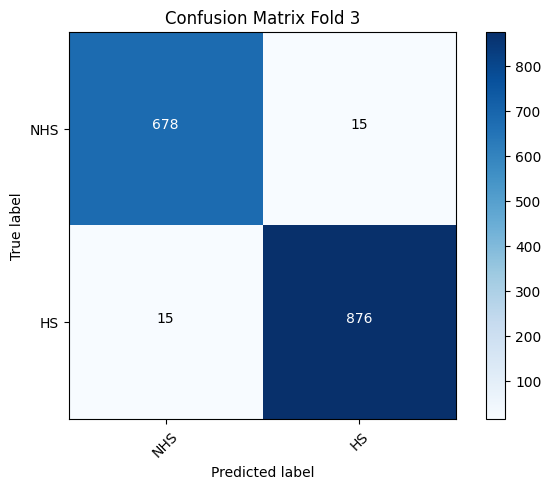

              precision    recall  f1-score   support

         NHS       0.98      0.98      0.98       693
          HS       0.98      0.98      0.98       891

    accuracy                           0.98      1584
   macro avg       0.98      0.98      0.98      1584
weighted avg       0.98      0.98      0.98      1584

Epoch 1/100
50/50 [==============================] - 10s 181ms/step - loss: 0.0308 - accuracy: 0.9946 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 2/100
50/50 [==============================] - 14s 289ms/step - loss: 0.0231 - accuracy: 0.9975 - val_loss: 0.0140 - val_accuracy: 1.0000
Epoch 3/100
50/50 [==============================] - 15s 305ms/step - loss: 0.0196 - accuracy: 0.9976 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 4/100
50/50 [==============================] - 13s 265ms/step - loss: 0.0170 - accuracy: 0.9981 - val_loss: 0.0136 - val_accuracy: 1.0000
Epoch 5/100
50/50 [==============================] - 9s 177ms/step - loss: 0.0150 - accuracy: 0.9

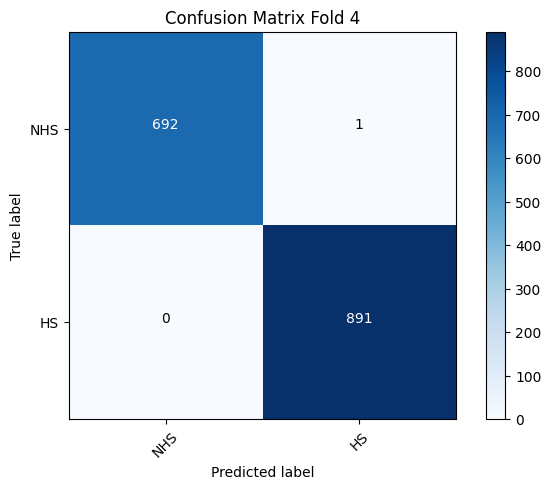

              precision    recall  f1-score   support

         NHS       1.00      1.00      1.00       693
          HS       1.00      1.00      1.00       891

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584

Epoch 1/100
50/50 [==============================] - 19s 343ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0017 - val_accuracy: 0.9994
Epoch 2/100
50/50 [==============================] - 22s 444ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 0.0020 - val_accuracy: 0.9994
Epoch 3/100
50/50 [==============================] - 17s 346ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 4/100
50/50 [==============================] - 14s 276ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 5/100
50/50 [==============================] - 14s 280ms/step - loss: 0.0026 - accuracy: 0.

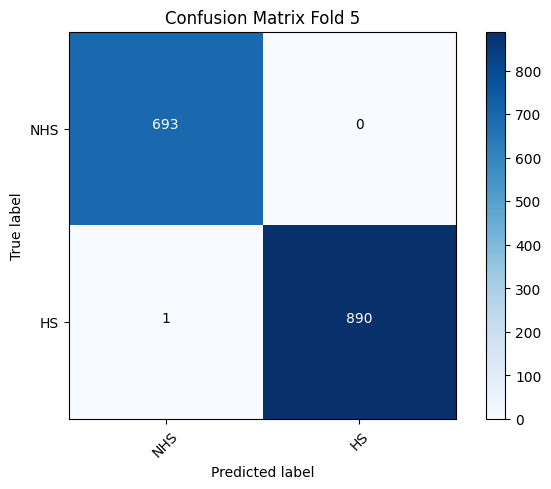

              precision    recall  f1-score   support

         NHS       1.00      1.00      1.00       693
          HS       1.00      1.00      1.00       891

    accuracy                           1.00      1584
   macro avg       1.00      1.00      1.00      1584
weighted avg       1.00      1.00      1.00      1584

Average metrics for CNN:
Average Accuracy: 0.9262
Average Precision: 0.9341
Average Recall: 0.9354
Average F1 Score: 0.9347



In [21]:
# Stratified cross-validation with 10 folds
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# DataFrame to store results
results_df = pd.DataFrame(columns=['Model', 'Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'history'])

output_dir = '/content/drive/MyDrive/seema'
# Training and evaluation loop for each model
for name, model in models:
    print(f'Training and evaluating {name} with {n_splits}-fold stratified cross-validation...')
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_pad, y), 1):
        X_train, X_val = X_pad[train_idx], X_pad[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        val_subs = df.iloc[val_idx]['Sub'].tolist()
        val_texts = df.iloc[val_idx]['Tweet'].tolist()

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

        # Define callbacks (checkpoint and early stopping)
        checkpoint = ModelCheckpoint(f'{output_dir}/checkpoints/cnn/non_trainable/{name}_fold{fold_idx}.h5', monitor='val_loss', save_best_only=True, verbose=0)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

        # Train the model with callbacks
        history = model.fit(X_train, y_train, epochs=100, batch_size=128,
                            validation_data=(X_val, y_val),
                            callbacks=[checkpoint, early_stopping],
                            verbose=1)

        # Load the best model for prediction
        best_model = load_model(f'{output_dir}/checkpoints/cnn/non_trainable/{name}_fold{fold_idx}.h5')

        # Evaluate the model on the validation set
        y_pred = (best_model.predict(X_val) > 0.5).astype(int)
        accuracy = accuracy_score(y_val, y_pred)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred)

        # Compute confusion matrix and plot
        cm = confusion_matrix(y_val, y_pred)
        plot_confusion_matrix(cm, classes=['NHS', 'HS'], title=f'Confusion Matrix Fold {fold_idx}')
        print(classification_report(y_val, y_pred, target_names=['NHS', 'HS']))

        # Prepare DataFrame with validation set tweets, true labels, predicted labels, and save
        val_df = pd.DataFrame({
            'Tweet': val_texts,
            'True Label': y_val,
            'Predicted Label': [x[0] for x in y_pred],
            'Sub': val_subs
        })
        val_df.to_excel(f'{output_dir}/results/cnn/non_trainable/cnn_val_set_with_preds_fold_{fold_idx}.xlsx', index=False)


        # Store the results for this fold
        fold_results.append([name, fold_idx, accuracy, precision, recall, f1, history.history])

    # Append fold results to the DataFrame
    results_df = pd.concat([results_df, pd.DataFrame(fold_results, columns=results_df.columns)],
                           ignore_index=True)


    # Calculate average metrics across all folds for this model
    avg_accuracy = np.mean(results_df[results_df['Model'] == name]['Accuracy'])
    avg_precision = np.mean(results_df[results_df['Model'] == name]['Precision'])
    avg_recall = np.mean(results_df[results_df['Model'] == name]['Recall'])
    avg_f1 = np.mean(results_df[results_df['Model'] == name]['F1 Score'])

    print(f'Average metrics for {name}:')
    print(f'Average Accuracy: {avg_accuracy:.4f}')
    print(f'Average Precision: {avg_precision:.4f}')
    print(f'Average Recall: {avg_recall:.4f}')
    print(f'Average F1 Score: {avg_f1:.4f}')
    print('')

# Save results to a CSV file
results_df.to_csv(f'{output_dir}/results/cnn/non_trainable/cnn_model_results.csv', index=False)

In [23]:
import pandas as pd
results_df = pd.read_csv(f'{output_dir}/results/cnn/non_trainable/cnn_model_results.csv')

In [25]:
results_df

,Model,Fold,Accuracy,Precision,Recall,F1 Score,history
0,CNN,1,0.765300,0.785088,0.802691,0.793792,"{'loss': [0.6758073568344116, 0.64735382795333..."
1,CNN,2,0.885804,0.903519,0.892377,0.897913,"{'loss': [0.3335222005844116, 0.31500804424285..."
2,CNN,3,0.981061,0.983165,0.983165,0.983165,"{'loss': [0.1459391862154007, 0.12942723929882..."
3,CNN,4,0.999369,0.998879,1.000000,0.999439,"{'loss': [0.030841106548905373, 0.023084493353..."
4,CNN,5,0.999369,1.000000,0.998878,0.999439,"{'loss': [0.004982903599739075, 0.003489280585..."


In [26]:
import ast

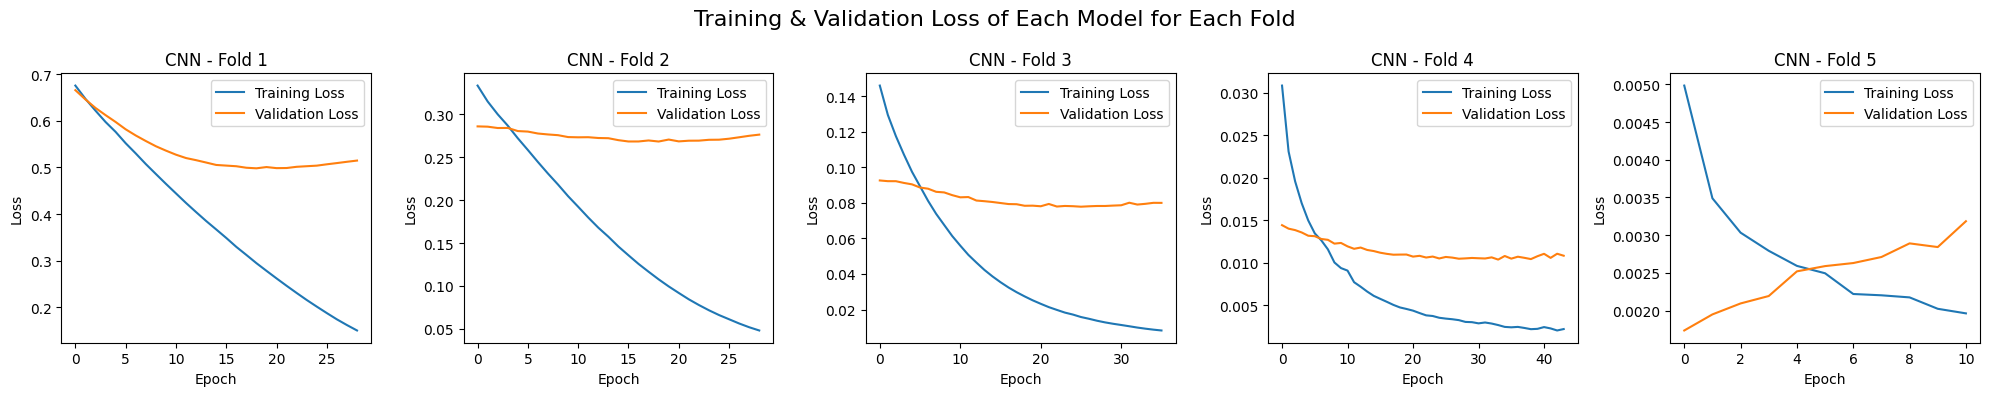

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the number of models and folds
num_models = len(results_df['Model'].unique())
num_folds = len(results_df['Fold'].unique())

# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(20, 4*1))
fig.suptitle('Training & Validation Loss of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[j].plot(history['loss'], label='Training Loss')
        axes[j].plot(history['val_loss'], label='Validation Loss')
        axes[j].set_title(f'{model} - Fold {fold}')
        axes[j].set_xlabel('Epoch')
        axes[j].set_ylabel('Loss')
        axes[j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


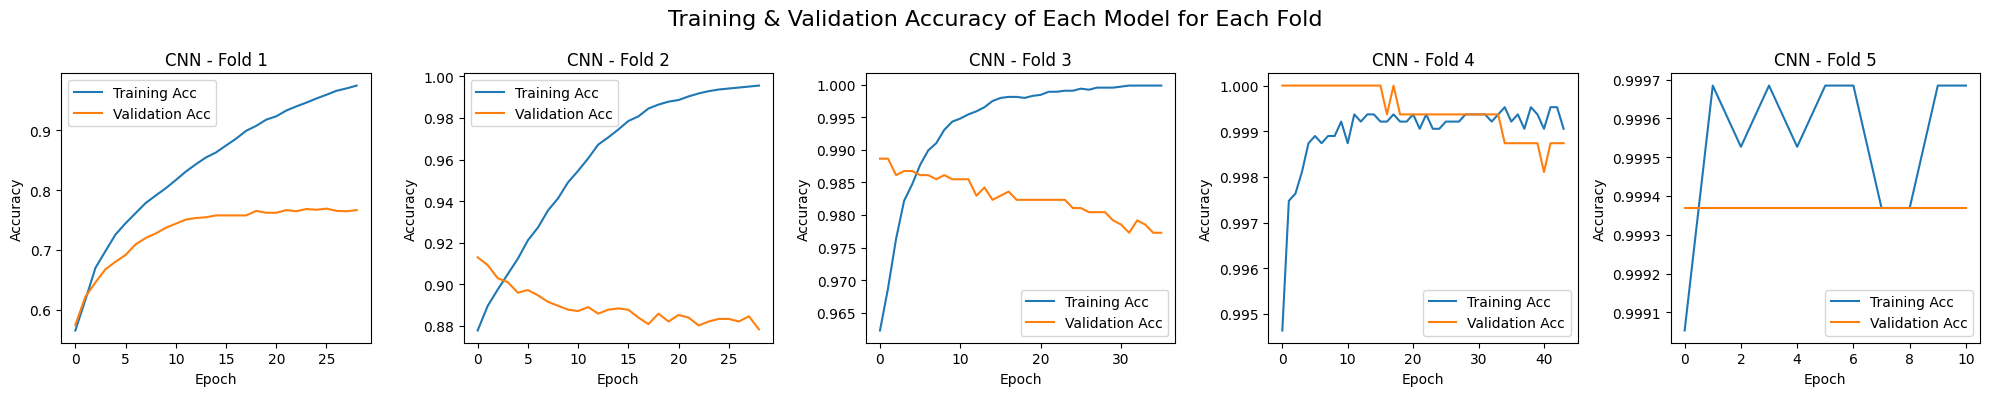

In [28]:
# Create subplots based on the number of models and folds
fig, axes = plt.subplots(num_models, num_folds, figsize=(20, 4*num_models))
fig.suptitle('Training & Validation Accuracy of Each Model for Each Fold', fontsize=16)

# Loop through each model and fold to plot the training history
for i, model in enumerate(results_df['Model'].unique()):
    for j, fold in enumerate(results_df['Fold'].unique()):
        # Filter the dataframe for the specific model and fold
        data = results_df[(results_df['Model'] == model) & (results_df['Fold'] == fold)]

        # Extract the history dictionary from the first row
        history = ast.literal_eval(data['history'].values[0])

        # Plot the training loss
        axes[j].plot(history['accuracy'], label='Training Acc')
        axes[j].plot(history['val_accuracy'], label='Validation Acc')
        axes[j].set_title(f'{model} - Fold {fold}')
        axes[j].set_xlabel('Epoch')
        axes[j].set_ylabel('Accuracy')
        axes[j].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
